In [1]:
# Import necessary libraries from PySpark
!pip install pyspark==3.1.2
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

# Import additional Python libraries
import os
import pandas as pd
import numpy as np

# Import PySpark related libraries
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

# Import PySpark ML (machine learning) libraries for feature transformation and classification
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import OneHotEncoder

# Import PySpark ML libraries for regression and evaluation
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
# Initialize a SparkSession with a specified master URL and application name
# Set the master URL to "local[]" to use all available cores on the local machine
# Set the application name to "Decision Tree"
# Create the SparkSession or retrieve an existing one   

spark=SparkSession.builder\
 .master("local[*]")\
 .appName("Neural Network")\
 .getOrCreate()
sc=spark.sparkContext

In [3]:
# Read CSV file into a PySpark DataFrame
df = spark.read.csv(
    path='/home/hadoop/Downloads/used_car_new.csv',  # Set the path to the CSV file
    header=True,  # Indicate that the first row of the CSV file contains column names
    inferSchema=True  # Infer the schema of the DataFrame from the CSV file
)

# Print the schema of the DataFrame
df.printSchema()

root
 |-- Sr: integer (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Mileage: integer (nullable = true)
 |-- NewCity: string (nullable = true)
 |-- NewState: string (nullable = true)
 |-- NewMake: string (nullable = true)
 |-- NewModel: string (nullable = true)



In [4]:
# Drop the "Sr" column from the DataFrame
df = df.drop("Sr")
df.show(10)

+-----+----+-------+----------+----------+-----------+-----------+
|Price|Year|Mileage|   NewCity|  NewState|    NewMake|   NewModel|
+-----+----+-------+----------+----------+-----------+-----------+
|22900|2017|   5363|  CLimited|SPlentiful|MAPlentiful| MOIsolated|
|14000|2011| 107273|CPlentiful|SPlentiful|MAPlentiful| MOIsolated|
|16795|2014|  31905| CIsolated|SPlentiful|MAPlentiful|MOPlentiful|
|11975|2010|  89254| CModerate|SPlentiful|MAPlentiful|MOPlentiful|
|12500|2009|  49160| CIsolated|SPlentiful|MAPlentiful| MOModerate|
|13712|2015|  51619| CIsolated|SPlentiful|MAPlentiful| MOIsolated|
|14995|2014|  81080| CModerate|SPlentiful|MAPlentiful|MOPlentiful|
|17970|2013|  50533| CIsolated|SPlentiful|MAPlentiful|MOPlentiful|
|27288|2015|  22873| CIsolated|SPlentiful|MAPlentiful|MOPlentiful|
|10030|2014|  51338|CPlentiful|SPlentiful|MAPlentiful| MOModerate|
+-----+----+-------+----------+----------+-----------+-----------+
only showing top 10 rows



In [5]:
# Create StringIndexer objects to convert categorical columns to numerical indices
city_indexer = StringIndexer(inputCol="NewCity", outputCol="CityIndex")
state_indexer = StringIndexer(inputCol="NewState", outputCol="StateIndex")
make_indexer = StringIndexer(inputCol="NewMake", outputCol="MakeIndex")
model_indexer = StringIndexer(inputCol="NewModel", outputCol="ModelIndex")

# Fit and transform the DataFrame using the StringIndexers
df = city_indexer.fit(df).transform(df)  # Convert "NewCity" column to numerical indices and store in "CityIndex" column
df = state_indexer.fit(df).transform(df)  # Convert "NewState" column to numerical indices and store in "StateIndex" column
df = make_indexer.fit(df).transform(df)  # Convert "NewMake" column to numerical indices and store in "MakeIndex" column
df = model_indexer.fit(df).transform(df)  # Convert "NewModel" column to numerical indices and store in "ModelIndex" column

# Show the first 10 rows of the transformed DataFrame
df.show(10)

+-----+----+-------+----------+----------+-----------+-----------+---------+----------+---------+----------+
|Price|Year|Mileage|   NewCity|  NewState|    NewMake|   NewModel|CityIndex|StateIndex|MakeIndex|ModelIndex|
+-----+----+-------+----------+----------+-----------+-----------+---------+----------+---------+----------+
|22900|2017|   5363|  CLimited|SPlentiful|MAPlentiful| MOIsolated|      1.0|       0.0|      0.0|       1.0|
|14000|2011| 107273|CPlentiful|SPlentiful|MAPlentiful| MOIsolated|      3.0|       0.0|      0.0|       1.0|
|16795|2014|  31905| CIsolated|SPlentiful|MAPlentiful|MOPlentiful|      0.0|       0.0|      0.0|       0.0|
|11975|2010|  89254| CModerate|SPlentiful|MAPlentiful|MOPlentiful|      2.0|       0.0|      0.0|       0.0|
|12500|2009|  49160| CIsolated|SPlentiful|MAPlentiful| MOModerate|      0.0|       0.0|      0.0|       2.0|
|13712|2015|  51619| CIsolated|SPlentiful|MAPlentiful| MOIsolated|      0.0|       0.0|      0.0|       1.0|
|14995|2014|  81080

In [6]:
# Create a VectorAssembler to combine specified columns into a single feature vector
assembler = VectorAssembler(
    inputCols=["Mileage", "Year", "CityIndex", "StateIndex", "MakeIndex", "ModelIndex"],
    outputCol="features"
)

# Transform the DataFrame using the VectorAssembler
df = assembler.transform(df)

# Drop the original categorical columns from the DataFrame
df = df.drop("NewCity", "NewState", "NewMake", "NewModel")



In [7]:
# Split the DataFrame into training (70%) and testing (30%) sets using a random seed for reproducibility
# Convert the PySpark DataFrame to a Pandas DataFrame
data_pd = df.select("features", "Price").toPandas()

# Convert the 'features' column in the Pandas DataFrame to a list of lists
X = data_pd["features"].apply(lambda x: x.toArray().tolist()).tolist()
y = data_pd["Price"].values



In [8]:

#train, test = df.randomSplit([0.7, 0.3], seed=123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Show the first 10 rows of the transformed DataFrame
df.show(10)

+-----+----+-------+---------+----------+---------+----------+--------------------+
|Price|Year|Mileage|CityIndex|StateIndex|MakeIndex|ModelIndex|            features|
+-----+----+-------+---------+----------+---------+----------+--------------------+
|22900|2017|   5363|      1.0|       0.0|      0.0|       1.0|[5363.0,2017.0,1....|
|14000|2011| 107273|      3.0|       0.0|      0.0|       1.0|[107273.0,2011.0,...|
|16795|2014|  31905|      0.0|       0.0|      0.0|       0.0|(6,[0,1],[31905.0...|
|11975|2010|  89254|      2.0|       0.0|      0.0|       0.0|[89254.0,2010.0,2...|
|12500|2009|  49160|      0.0|       0.0|      0.0|       2.0|[49160.0,2009.0,0...|
|13712|2015|  51619|      0.0|       0.0|      0.0|       1.0|[51619.0,2015.0,0...|
|14995|2014|  81080|      2.0|       0.0|      0.0|       0.0|[81080.0,2014.0,2...|
|17970|2013|  50533|      0.0|       0.0|      0.0|       0.0|(6,[0,1],[50533.0...|
|27288|2015|  22873|      0.0|       0.0|      0.0|       0.0|(6,[0,1],[2287

In [9]:
# Create RegressionEvaluator objects for evaluating the model using R2, RMSE, and MAE metrics 
#for final decision c=700 because we can not any more good performence after c=700

r2_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol="Price", metricName='r2')
rmse_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol="Price", metricName='rmse')
mae_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol="Price", metricName='mae')
mse_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol="Price", metricName='mse')

In [10]:
# Create an SVR object and train the model C=100
svr = SVR(kernel="rbf", C=100, epsilon=0.1)
svr.fit(X_train, y_train)

SVR(C=100)

In [11]:
# Make predictions
y_pred = svr.predict(X_test)

# Compute the performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#check output for C=100
# Calculate R2, RMSE, and MAE metrics for the predictions
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


# Print the evaluation metrics
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("Mean Absolute Error (MAE) on test data = %g" % mae)
print("R-Squared (R2) on test data = %g" % r2)
print("Mean Squared Error (MSE) on test data = %g" % mse)


Root Mean Squared Error (RMSE) on test data = 12204.2
Mean Absolute Error (MAE) on test data = 7443.54
R-Squared (R2) on test data = 0.169287
Mean Squared Error (MSE) on test data = 1.48943e+08


In [12]:
# Create an SVR object and train the model C=500
svr = SVR(kernel="rbf", C=500, epsilon=0.1)
svr.fit(X_train, y_train)

SVR(C=500)

In [13]:
# Make predictions
y_pred = svr.predict(X_test)

# Compute the performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
#check output for C=500
# Calculate R2, RMSE, and MAE metrics for the predictions
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


# Print the evaluation metrics
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("Mean Absolute Error (MAE) on test data = %g" % mae)
print("R-Squared (R2) on test data = %g" % r2)
print("Mean Squared Error (MSE) on test data = %g" % mse)


Root Mean Squared Error (RMSE) on test data = 12130
Mean Absolute Error (MAE) on test data = 7420.22
R-Squared (R2) on test data = 0.179355
Mean Squared Error (MSE) on test data = 1.47138e+08


In [14]:
# Create an SVR object and train the model C=700
svr = SVR(kernel="rbf", C=700, epsilon=0.1)
svr.fit(X_train, y_train)

SVR(C=700)

In [36]:
# Make predictions
y_pred = svr.predict(X_test)

# Compute the performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
#check output for C=700
# Calculate R2, RMSE, and MAE metrics for the predictions
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


# Print the evaluation metrics
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("Mean Absolute Error (MAE) on test data = %g" % mae)
print("R-Squared (R2) on test data = %g" % r2)
print("Mean Squared Error (MSE) on test data = %g" % mse)


Root Mean Squared Error (RMSE) on test data = 12120.7
Mean Absolute Error (MAE) on test data = 7419.48
R-Squared (R2) on test data = 0.180613
Mean Squared Error (MSE) on test data = 1.46912e+08


In [37]:
# Create an SVR object and train the model C=1000
svr = SVR(kernel="rbf", C=1000, epsilon=0.1)
svr.fit(X_train, y_train)

SVR(C=1000)

In [15]:
# Make predictions
y_pred = svr.predict(X_test)

# Compute the performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
#check output for C=1000
# Calculate R2, RMSE, and MAE metrics for the predictions
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


# Print the evaluation metrics
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("Mean Absolute Error (MAE) on test data = %g" % mae)
print("R-Squared (R2) on test data = %g" % r2)
print("Mean Squared Error (MSE) on test data = %g" % mse)


Root Mean Squared Error (RMSE) on test data = 12120.7
Mean Absolute Error (MAE) on test data = 7419.48
R-Squared (R2) on test data = 0.180613
Mean Squared Error (MSE) on test data = 1.46912e+08


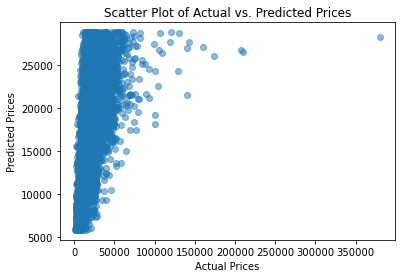

In [16]:
# Import the necessary library for creating plots
import matplotlib.pyplot as plt

# Assuming y_test is the true target values and y_pred is the predicted values from your SVM model, both as NumPy arrays

# Create a scatter plot comparing actual prices (y-axis) and predicted prices (x-axis)
plt.scatter(y_test, y_pred, alpha=0.5)
# Set the labels for the x-axis and y-axis
plt.xlabel("Actual Prices") # Collect actual prices from the 'Price' column of the predictions DataFrame
plt.ylabel("Predicted Prices")# Collect predicted prices from the 'prediction' column of the predictions DataFrame
# Set the title of the scatter plot
plt.title("Scatter Plot of Actual vs. Predicted Prices")
# Save the scatter plot to a file (e.g., 'scatter_plot.png')
plt.savefig('scatterplot_SVM_HPCI.png' , dpi=200, bbox_inches='tight')

# Display the scatter plot
plt.show()